This file contains a CNN implementation for categorizing music by their genre, given their Mel spectrograms.

In [1]:
#Loading libraries

#Pytorch, plotting
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch import Tensor
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import Subset

#General/other
from typing import Set, Tuple, List
import numpy as np
import random, time
from pathlib import Path
import os, math

In [27]:
#Useful functions

def augment_training(data_folder: ImageFolder, split: int, noise_seed: int = 547, noise_multiplier: float = 0.6) -> ImageFolder:
    """
    Augments the given data by adding random noise into it. Returns merge of original data and augmented data (as an ImageFolder).

    Use noise_seed to manually set the random seed used to add the noise. use the noise_multiplier to define how strong the noise is

    The data is subset up to the given split
    """

    #Splitting given ImageFolder
    split_data: Subset = Subset(data_folder, list(range(0, min(split, len(data_folder)))))

    #Setting noise seed
    torch.manual_seed(noise_seed)

    # Adding noise, printing some examples
    count: int = 0
    data_to_add: List[Tuple] = list() #saves all image configurations to add to ImageFolder
    for index, data in enumerate(split_data, 0): #iterating given ImageFolder
        image_data_list: List[object] = list() #List to store elements into

        img_class: int = data[1]
        image: Tensor = data[0]
        
        #Adding noise to image
        noisy_img = image + noise_multiplier * torch.rand(*image.shape) #creating random tensor matching shape of image, adding random noise
        noisy_img = np.clip(noisy_img, -1., 1.)

        #printing noisy image
        if count != 4 and index % 100 == 0:
            count += 1
            noisy_plot = np.transpose(noisy_img, [1,2,0]) #resetting image channel back to the end
            noisy_plot = noisy_plot*0.5 + 0.5
            plt.subplot(2,2, count)
            plt.imshow(noisy_plot)

        #Adding elements to datapoint
        image_data_list.append(noisy_img)
        image_data_list.append(img_class)
        image_data: Tuple[object] = tuple(image_data_list)#image data tuple

        data_to_add.append(image_data) #adding entry to list of entries to add

    #Adding entries to data folder
    split_data = split_data + data_to_add

    print(f"Training dataset length with noisy images added: {len(split_data)}")

    return split_data

def plot_training_curve(path: str):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/accuracy.

    Args:
        path: The base path of the csv files produced during training
    """
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def get_model_name(name: str, batch_size: int, learning_rate: float, epoch: int, dropout_prob: float):
    """ Generate a name for the model consisting of all the hyperparameter values.

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_dr{1}_lr{2}_epoch{3}_bs{4}".format(name,
                                                   dropout_prob,
                                                   learning_rate,
                                                   epoch,
                                                   batch_size)
    return path

def get_correct(outputs: Tensor, labels: Tensor) -> int:
    """
    Finds number of matching inferences to expected labels.

    Assumes that outputs is given as the raw output from the neural network's forward function. 
    """
    #Getting predictions from outputs:
    preds: Tensor = outputs.max(1, keepdim=True).indices.squeeze(dim=1) #Checks max probability for each inference, keeps the indices (classes) predicted and
    # reshapes to match the labels' shape (squeezes to a one dimensional Tensor)
    
    correct: int = int(preds.eq(labels).sum().item()) #checks how many predictions match labels. Adds up results and extracts count of matches.

    return correct

def get_model_path(model: nn.Module, lr: float, batch_size: int, epoch: int, at_epoch: int = 0) -> Path:
    if at_epoch == 0:
        at_epoch = epoch

    return Path(os.getcwd())/'training_data'/f'{
        get_model_name(model.name,
                batch_size=batch_size, learning_rate=lr, epoch=epoch, dropout_prob=model.dropout_prob)
        }'/f'{
        get_model_name(model.name,
                batch_size=batch_size, learning_rate=lr, epoch=at_epoch-1, dropout_prob=model.dropout_prob)
        }'

def evaluate(net: nn.Module, loader: DataLoader, criterion: nn.Module, use_gpu: bool) -> Tuple[float, float]:
    """
    Evaluate the network on the given loader.

    Returns the total loss and accuracy of the model, on the given loader.
    """

    total_loss: float = 0.0
    total_acc: int = 0
    total_epoch: int = 0
    for i, data in enumerate(loader, 0):
        # Get the inputs
        images: Tensor = data[0]
        labels: Tensor = data[1]

        #Checking if GPU training is available/selected
        if use_gpu and torch.cuda.is_available:
            images = images.cuda()
            labels = labels.cuda()

        #Making inference, getting results
        outputs: Tensor = net(images)
        loss: Tensor = criterion(outputs, labels)
        total_acc += get_correct(outputs, labels)
        total_loss += loss.item()
        total_epoch += len(labels)

    acc: float = float(total_acc) / total_epoch
    loss: float = total_loss / (i + 1)
    return acc, loss

def seed_worker(worker_id: int) -> None:
    worker_seed: int = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def load_randomized_loaders(
        data_path: str, #path to search for images/classes
        batch_size: int, #batch size to use for loaders
        shuffle_seed: int = 527, #for reproducibility; defaults to 527
        splits: List[float] = [0.8, 0.1, 0.1], #split to use for training, validation, testing
        n_workers: int = 0, #number of workers to use for loaders
        augment: bool = True #Whether to augment training data
        ) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Returns a randomized split of the given images_folder data into three loaders (one for training, one for validation, and one for testing).
    Data is shuffled and then split into the three loaders, with the given splits.

    data_path: Path to the images we would like to load and split.
    shuffle_seed: Seed used to shuffle the ImageFolder data; used to determine the new order after shuffling.
    splits: Percentage to assing to training, to validation, and to testing, respectively.
    batch_size: Batch size to use for the returned loaders (samples per batch).

    Returns tuple of three data loaders, in the order of: training loader, validation loader, testing loader.
    """

    #Verifying split integrity
    assert sum(splits) == 1.0, "The provided splits do not add up to one"

    #Defining transforms to apply to images
    trns: transforms.Compose = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]
    ) #Transforms images to tensors, then applies (img - 0.5)/0.5 to all channels to obtain data in range [-1, 1]

    #Getting data from provided path as an ImageFolder
    data_folder: ImageFolder = ImageFolder(root=data_path, transform=trns)
    data_indices: list = list(range(0, len(data_folder), 1)) #getting list of indices in loaded data

    #Setting up random seeds, and splitting data
    np.random.seed(shuffle_seed)
    np.random.shuffle(data_indices) #shuffling data indices
    training_split: int = int(len(data_indices) * splits[0]) #getting first position to split at (ends training data split)
    validation_split: int = int(len(data_indices) * sum(splits[:2])) #getting second position to split at (ends validation data split)
    
    g: torch.Generator = torch.Generator() #defining generic generator, to use with each DataLoader
    g.manual_seed(shuffle_seed) #setting generator seed, to help ensure reproducibility

    #Getting split indices, creating data loaders
    train_indices, validation_indices, testing_indices = data_indices[:training_split], data_indices[training_split:validation_split], data_indices[validation_split:]

    #Special settings for train dataset if augmenting data
    if augment: 
        augmented_training: ImageFolder = augment_training(data_folder, training_split, noise_seed=shuffle_seed)
        train_indices: list = list(range(0, len(augmented_training), 1))
        train_sampler: SubsetRandomSampler = SubsetRandomSampler(train_indices, generator=g)
        train_loader: DataLoader = DataLoader(dataset=augmented_training, batch_size=batch_size,
                                              num_workers=n_workers, worker_init_fn=seed_worker, sampler=train_sampler)

    else:
        train_sampler: SubsetRandomSampler = SubsetRandomSampler(train_indices, generator=g) #note the use of the custom generator we defined earlier
        train_loader: DataLoader = DataLoader(dataset=data_folder, batch_size=batch_size,
                                            num_workers=n_workers, worker_init_fn=seed_worker, sampler=train_sampler) #note the use of the worker init function
    validation_sampler: SubsetRandomSampler = SubsetRandomSampler(validation_indices, generator=g)
    validation_loader: DataLoader = DataLoader(dataset=data_folder, batch_size=batch_size,
                                        num_workers=n_workers, worker_init_fn=seed_worker, sampler=validation_sampler)
    test_sampler: SubsetRandomSampler = SubsetRandomSampler(testing_indices, generator=g)
    test_loader: DataLoader = DataLoader(dataset=data_folder, batch_size=batch_size,
                                        num_workers=n_workers, worker_init_fn=seed_worker, sampler=test_sampler)
    
    #Returning loaders
    return train_loader, validation_loader, test_loader

We will now proceed to create training, validation, and testing loaders.

For this initial training, the team used the gtzan music dataset.
For more details on how the data was loaded and processed, please see the 'Spectrograms.ipynb' script.

torch.Size([3, 308, 775])


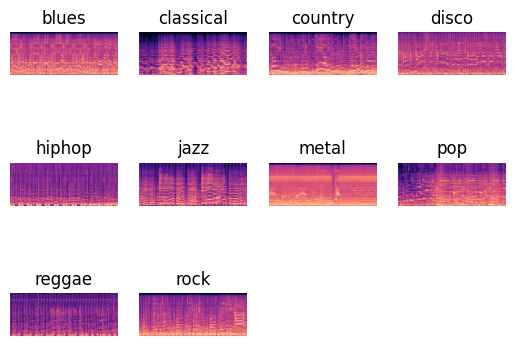

In [3]:
#Splitting into training, validation and testing datasets. Can provide randomizing seed, to help replicate results.

spectrograms_path: str = r'Mel_Spectrograms'

classification_dict: dict[int, str] = {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}

train_loader, validation_loader, test_loader = load_randomized_loaders(data_path=spectrograms_path,
                                                                       batch_size=1, augment=False)

#Visualizing classes as spectrograms of the genres
seen_classes: Set[int] = set()
showed_shape: bool = False
for images, labels in train_loader:
    image: Tensor = images[0] #batch size of one, so just get single image in batch
    target_class: int = int(labels[0]) #getting current image's class
    if target_class not in seen_classes:
        seen_classes.add(target_class)
        #Image shape, values
        if not showed_shape:
            print(image.shape)
            showed_shape = True

        #Plotting
        image = np.transpose(image, [1,2,0]) #resetting image channel back to the end
        #resetting transformation
        img_max = image.max()
        img_min = image.min()
        image = (image - img_min) / (img_max - img_min)
        plt.subplot(3, 4, target_class+1)
        plt.axis('off')
        plt.title(classification_dict[target_class])
        plt.imshow(image)

The above is a visualization of the genres; it can already be seen that spectrograms show unique characteristics for each genre.

For example, the metal example is very loud, as shown on the high decibels on its corresponding spectrograms, while the reggae spectrogram is more 'relaxed'.

In [4]:
print(f"Training examples: {len(train_loader)}\nValidation examples: {len(validation_loader)}\nTesting examples: {len(test_loader)}")

Training examples: 799
Validation examples: 100
Testing examples: 100


Although the team will expand the number of examples in the future, we only have 1000 to work with right now.

These have been split into 80% training, 10% validation, and 10% testing.

In [6]:
#Importing VGG16, and modifying classifier.
vgg_16: nn.Module = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16_bn', pretrained=True)

Using cache found in C:\Users\Durango/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\Durango\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Durango\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


For this task, the 2014 ImageNet second place winner VGG 16 will be preloaded.

A slightly different classifier will be created for it.

In [ ]:
#Creating loader that saves tuples of features, labels
def save_features(loader: DataLoader, net: nn.Module, use_gpu: bool = True) -> List[Tuple[Tensor, Tensor]]:
    """
    Takes the given network structure and processes the given loader on it.

    Returns two tensors: one for the resulting features, and one for the true labels for the given features, in that order.
    """

    total_data: List[Tuple[Tensor, Tensor]] = list() #Defininig initial list to save all our results to

    if use_gpu and torch.cuda.is_available:
        net = net.cuda()

    for images, labels in loader: #Iterating batches in loader
        #Checking if GPU training is available/selected
        if use_gpu and torch.cuda.is_available:
            images: Tensor = images.cuda()
            labels: Tensor = labels.cuda()

        with torch.no_grad(): #stop keeping track of grads, no need to update model
            features: Tensor = net.features(images)

        curr_data: Tuple = tuple([torch.from_numpy(features.detach().cpu().numpy()), labels]) #Creating current data tuple
        #Forces features tensor as a numpy array, then reads it back as a tensor

        total_data.append(curr_data) #Appending to total data list

    return total_data

In [15]:
#Saving features for loaders

#Creating new loaders with batch size of 32

train_loader, validation_loader, test_loader = load_randomized_loaders(r'Mel_Spectrograms', batch_size=32, augment=False)


train_vgg: List[Tuple[Tensor, Tensor]] = save_features(train_loader, vgg_16)
val_vgg: List[Tuple[Tensor, Tensor]] = save_features(validation_loader, vgg_16)
test_vgg: List[Tuple[Tensor, Tensor]] = save_features(test_loader, vgg_16)

In [17]:
for features, labels in train_vgg:
    print(features.shape)
    print(labels.shape)
    break

torch.Size([32, 512, 9, 24])
torch.Size([32])


We will now create a classifier for the extracted features.

In [28]:
#Note that spectrogram outputs (features) are of size 512 x 9 x 24
#Note that all the convolution operations preserve the resolution of the image, but each max pooling halves the image dimension

class genre_classifier(nn.Module):
    def __init__(self, dropout_prob: float = 0.3):
        super(genre_classifier, self).__init__()
        self.name = "genre_classifier"
        self.dropout_prob = dropout_prob
        self.dropout = nn.Dropout(p = self.dropout_prob) #custom dropout prob; only used for fully connected classifier

        #FC layers
        self.fc1 = nn.Linear(512 * 9 * 24, 4096)
        self.fc2 = nn.Linear(4096, 512)
        self.softmax = nn.Linear(512, 10) #this layer simply transforms the last fully connected output tensor to have size ten (number of classes we have) for its last dimension

    def forward(self, x: Tensor):
        #Fully connected
        x = x.view(-1, 512 * 9 * 24) #Stacking last pooling output
        x = F.relu(self.dropout(self.fc1(x))) #Applying fully connected layer, then dropout, then ReLU activation.
        x = F.relu(self.dropout(self.fc2(x)))
        x = self.softmax(x) #Softmax is to be applied by the CrossEntroy loss fn during training, or directly apply softmax on output for testing
        return x

The above code is adapted from VGG16 (citation).

In [36]:
def train_classifier(
        train_loader: List[Tuple[Tensor, Tensor]], #Custom made features, labels 'loaders'
        val_loader: List[Tuple[Tensor, Tensor]],
        net: nn.Module, #Network to use for training
        batch_size: int = 32, #Batch size for training
        learning_rate: float = 3*math.e**(-4), #Learning rate for training
        num_epochs: int = 40, #Number of epochs for training
        seed: int = 527, #Random seed
        use_gpu: bool = True, #Whether to use GPU for training or not
        weight_decay: float = 5e-4 #How much weight decay to use (lambda)
        ) -> None:
    #Performing CUDA checks
    if use_gpu and not next(net.parameters()).is_cuda:
        print("WARNING: Intended to use CUDA for training, but passed model not on CUDA.")

    if use_gpu and torch.cuda.is_available:
        print(f"Training on GPU '{torch.cuda.get_device_name()}'")
    elif use_gpu and not torch.cuda.is_available:
        print("GPU is not available, training with CPU instead")

    #Printing settings
    print(f"Batch size: {batch_size}\tLearning rate: {learning_rate}\tEpochs: {num_epochs}")
    try:
        print(f"Using dropout: {net.dropout_prob}")
    except:
        print("No dropout implemented")
    print(f"Weight decay: {weight_decay}")

    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(seed)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be the Cross Entropy Loss function, which combines softmax and Negative Log Likelihood loss
    # into one.
    # Optimizer will be SGD with Momentum.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/accuracy
    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()

    #creating savepath for epochs settings, error and loss stats
    training_data_path: Path = Path(os.getcwd())/'training_data'/get_model_name(name=net.name, batch_size=batch_size, learning_rate=learning_rate,
                                                                                epoch=num_epochs, dropout_prob=net.dropout_prob)
    #getting current working directory, then adding model data to path
    if not os.path.exists(training_data_path):
        os.makedirs(training_data_path) #creating dir to save data to

    #Iterating epochs, entering main training loop
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss: float = 0.0
        total_train_correct: int = 0
        total_epoch: int = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            features: Tensor = data[0]
            labels: Tensor = data[1]

            #Checking if GPU training is available/selected
            if use_gpu and torch.cuda.is_available:
                features = features.cuda()
                labels = labels.cuda()

            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs: Tensor = net(features)
            loss: Tensor = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            #Calculate the statistics
            total_train_correct += get_correct(outputs, labels)
            total_train_loss += loss.item()
            total_epoch += len(labels)

        train_acc[epoch] = float(total_train_correct) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_acc[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion, use_gpu=use_gpu)
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   train_loss[epoch],
                   val_acc[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path: Path = training_data_path/get_model_name(net.name, batch_size, learning_rate, epoch, net.dropout_prob) #adding file name to path
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

This function is used to train the classifier.

In [37]:
classifier = genre_classifier(dropout_prob= 0.5)
gpu: bool = True

if torch.cuda.is_available and gpu:
    classifier = classifier.cuda()

train_classifier(train_vgg, val_vgg, net=classifier, use_gpu=gpu, learning_rate=0.1*3*math.e**(-4), num_epochs=10)

Training on GPU 'NVIDIA GeForce RTX 2080 Ti'
Batch size: 32	Learning rate: 0.005494691666620257	Epochs: 10
Using dropout: 0.5
Weight decay: 0.0005
Epoch 1: Train acc: 0.2590738423028786, Train loss: 2.1984342765808105 |Validation acc: 0.41, Validation loss: 2.0194350481033325
Epoch 2: Train acc: 0.5556946182728411, Train loss: 1.4563253045082092 |Validation acc: 0.47, Validation loss: 1.3911541402339935
Epoch 3: Train acc: 0.769712140175219, Train loss: 0.7278458821773529 |Validation acc: 0.57, Validation loss: 0.910757027566433
Epoch 4: Train acc: 0.9173967459324155, Train loss: 0.2936519578099251 |Validation acc: 0.67, Validation loss: 0.9971764832735062
Epoch 5: Train acc: 0.9724655819774718, Train loss: 0.12334010615944863 |Validation acc: 0.64, Validation loss: 1.1943752467632294
Epoch 6: Train acc: 0.9987484355444305, Train loss: 0.028203527629375457 |Validation acc: 0.7, Validation loss: 1.0573927760124207
Epoch 7: Train acc: 1.0, Train loss: 0.014155769739300012 |Validation acc

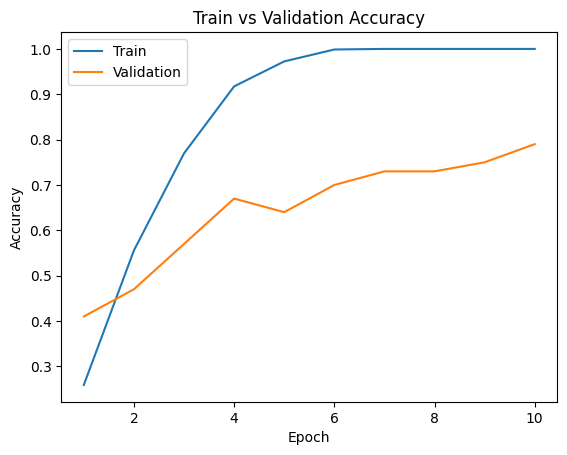

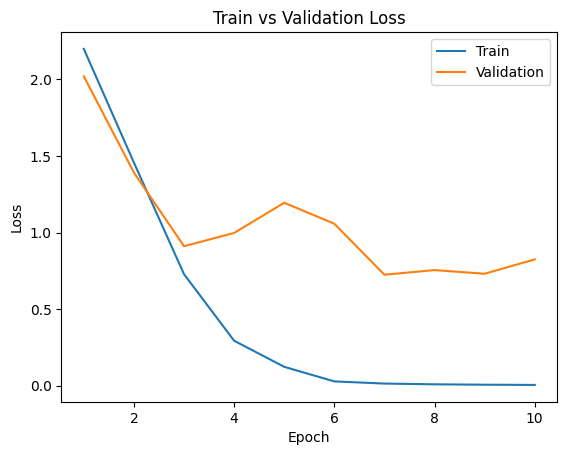

In [38]:
#Plotting results
model_path = get_model_path(model = classifier, lr = 0.1*3*math.e**(-4), batch_size = 32, epoch = 10)
plot_training_curve(model_path)

We will now run the testing data with our best model.

In [39]:
#Loading best model
#Loading best model
best_classifier = genre_classifier(dropout_prob=0.5)

if torch.cuda.is_available:
    best_classifier = best_classifier.cuda()

model_path = get_model_path(best_classifier, 0.1*3*math.e**(-4), 32, 10, 8)
state = torch.load(model_path)
best_classifier.load_state_dict(state)

C:\Users\Durango\AppData\Local\Temp\ipykernel_1484\1020238684.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


<All keys matched successfully>

In [ ]:
#Testing best model

test_acc, test_loss = evaluate(best_classifier, test_vgg, criterion=nn.CrossEntropyLoss(), use_gpu=True)

print(f"Test accuracy: {test_acc}\nTest loss: {test_loss}")